In [1]:
# Constants
DATA_PATH   = "../Data/Processed/3_engineered_df.pkl"

TECH_JOBS = ['Techjobs']

CORE_COLS = ['VersionControlSystem',
             'Languages',
             'Databases',
             'Platforms',
             'WebFrameworks',
             'MiscTech',
             'ToolsTech',
             'CollabTools'
]


MLFLOW_TRACKING_URI = '../models/mlruns'
MLFLOW_EXPERIMENT_NAME = "tech_jobs_predictions"

LOG_PATH = "../models/temp/"
LOG_DATA_PKL    =  "data.pkl"
LOG_MODEL_PKL   =  "model.pkl"
LOG_METRICS_PKL =  "metrics.pkl"

In [2]:
# Load packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import logging
import pickle
from pathlib import Path
import os

import mlflow
from mlflow.tracking import MlflowClient


from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score,ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import cross_val_score, cross_validate,cross_val_predict, GridSearchCV

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

_____

### Functions

In [3]:
def calculate_quality(ground_truth, predictions, metric_function, sort_values=False):
    quality_scores = {}
    for col in predictions.columns:
        role_pred  = predictions[col].copy()
        role_truth = ground_truth[col].copy()
        if metric_function == accuracy_score:
            quality_scores[col] = round(metric_function(role_truth, role_pred) * 100, 2)
        else: 
            quality_scores[col] = round(metric_function(role_truth, role_pred,zero_division=0,average='macro') * 100, 2)
        
    quality_scores = pd.Series(quality_scores.values(), index=quality_scores.keys())
    if sort_values:
        quality_scores = quality_scores.sort_values()
    
    return quality_scores

In [4]:
def calculate_scores(clf, x, y):
    y_pred = clf.predict(x)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro',zero_division=0.0)
    recall = recall_score(y, y_pred, average='macro',zero_division=0.0)
    f1 = f1_score(y, y_pred, average='macro',zero_division=0.0)
    
    return {'accuracy': accuracy,
            'precision':precision,
            'recall': recall,
           'f1' : f1}

_____

In [5]:
# Load dataset and make a copy
eng_df = pd.read_pickle(DATA_PATH)
df = eng_df.copy()

In [6]:
df

Techjobs                 \
      Data scientist or machine learning specialist Engineer, data   
2                                                 1              1   
3                                                 0              0   
9                                                 0              0   
10                                                0              0   
12                                                0              0   
...                                             ...            ...   
73262                                             0              0   
73263                                             0              0   
73264                                             1              0   
73265                                             0              0   
73266                                             0              0   

                                                                           \
      Data or business analyst Developer, back-end Database administrator   
2                            0                   0                      0   
3                            0                   0                      0   
9                            0                   0                      0   
10                           0                   1                      0   
12                           0                   0                      0   
...                        ...                 ...                    ...   
73262                        0                   0                      0   
73263                        0                   1                      0   
73264                        0                   0                      0   
73265                        0                   0                      0   
73266                        0                   0                      0   

                                                                             \
      Developer, mobile Developer, full-stack Cloud infrastructure engineer   
2                     0                     0                             0   
3                     0                     1                             0   
9                     1                     0                             0   
10                    0                     1                             0   
12                    0                     1                             0   
...                 ...                   ...                           ...   
73262                 0                     0                             0   
73263                 0                     0                             0   
73264                 0                     0                             0   
73265                 0                     1                             0   
73266                 0                     0                             0   

                                                                         \
      Developer, embedded applications or devices Developer, QA or test   
2                                               0                     0   
3                                               0                     0   
9                                               0                     0   
10                                              0                     0   
12                                              0                     0   
...                                           ...                   ...   
73262                                           0                     0   
73263                                           0                     0   
73264                                           0                     0   
73265                                           0                     0   
73266                                           0                     0   

                                                            \
      System administrator Scientist Security professional   
2 

### Deal with Imbalanced Dataset

In [7]:
one_job_df = df[df['Techjobs'].sum(axis=1) ==1]

In [8]:
len(one_job_df)

23154

In [9]:
one_job_df[TECH_JOBS].sum(axis=0).sort_values()

Techjobs  Blockchain                                         56
          Database administrator                             62
          Scientist                                         127
          Security professional                             146
          Cloud infrastructure engineer                     170
          Developer, game or graphics                       215
          System administrator                              215
          DevOps specialist                                 278
          Data or business analyst                          315
          Developer, QA or test                             351
          Engineer, data                                    370
          Academic researcher                               440
          Data scientist or machine learning specialist     582
          Developer, embedded applications or devices       659
          Developer, desktop or enterprise applications     869
          Developer, mobile             

In [10]:
X = one_job_df.drop(one_job_df[TECH_JOBS],axis = 1).droplevel(0,axis=1).reset_index(drop=True)
y = one_job_df[TECH_JOBS].droplevel(0,axis = 1).copy()
y = pd.from_dummies(y)

In [11]:
from sklearn.model_selection import StratifiedKFold
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


for train_index, test_index in skf.split(X, y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [12]:
y_train.value_counts()

Developer, full-stack                            6344
Developer, back-end                              4735
Developer, front-end                             2254
Developer, mobile                                1307
Developer, desktop or enterprise applications     695
Developer, embedded applications or devices       527
Data scientist or machine learning specialist     466
Academic researcher                               352
Engineer, data                                    296
Developer, QA or test                             281
Data or business analyst                          252
DevOps specialist                                 222
Developer, game or graphics                       172
System administrator                              172
Cloud infrastructure engineer                     136
Security professional                             117
Scientist                                         102
Database administrator                             49
Blockchain                  

In [13]:
y_test.value_counts()

Developer, full-stack                            1586
Developer, back-end                              1183
Developer, front-end                              564
Developer, mobile                                 326
Developer, desktop or enterprise applications     174
Developer, embedded applications or devices       132
Data scientist or machine learning specialist     116
Academic researcher                                88
Engineer, data                                     74
Developer, QA or test                              70
Data or business analyst                           63
DevOps specialist                                  56
Developer, game or graphics                        43
System administrator                               43
Cloud infrastructure engineer                      34
Security professional                              29
Scientist                                          25
Database administrator                             13
Blockchain                  

# apply smote to 1 job df
x_train = one_job_df.drop(one_job_df[TECH_JOBS],axis = 1).droplevel(0,axis=1).copy()
y_train = one_job_df[TECH_JOBS].droplevel(0,axis = 1).copy()

y_train_array = y_train.to_numpy()

In [14]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
over = SMOTE(random_state=42, k_neighbors=5)
under= RandomUnderSampler(random_state=42 ,sampling_strategy={'Developer, full-stack':1000,'Developer, back-end':1000,'Developer, front-end':1000,'Developer, mobile':1000})
x_under, y_under= under.fit_resample(x_train, y_train)
x_over, y_over = over.fit_resample(x_under, y_under)

In [15]:
y_over.value_counts()

Academic researcher                              1000
Developer, embedded applications or devices      1000
Security professional                            1000
Scientist                                        1000
Engineer, data                                   1000
Developer, mobile                                1000
Developer, game or graphics                      1000
Developer, full-stack                            1000
Developer, front-end                             1000
Developer, desktop or enterprise applications    1000
Blockchain                                       1000
Developer, back-end                              1000
Developer, QA or test                            1000
DevOps specialist                                1000
Database administrator                           1000
Data scientist or machine learning specialist    1000
Data or business analyst                         1000
Cloud infrastructure engineer                    1000
System administrator        

y_train_under= pd.DataFrame(y_under, index= x_under.index,columns = y_train.columns)

y_train_under.sum(axis=0).sort_values()

y_train_over = pd.DataFrame(y_over, index= x_over.index,columns = y_train.columns)

y_train_over.sum(axis = 0)

len(y_train_over)

### Create a Test Set

In [7]:
X = df.drop(df[TECH_JOBS],axis = 1).droplevel(0,axis=1).copy()
y = df[TECH_JOBS].droplevel(0,axis = 1).copy()

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y,test_size=0.20,
                                                    random_state=42)

### Intialize MLflow

In [16]:
# Create Directories
Path(MLFLOW_TRACKING_URI).mkdir(parents=True, exist_ok=True)
Path(LOG_PATH).mkdir(parents=True, exist_ok=True)

In [17]:
# Initialize client and experiment
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient()
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
exp = client.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)

### Create a Baseline Model

In [18]:
# Create a Logistic Regression Classifier
log_clf = make_pipeline(StandardScaler(),
                    MultiOutputClassifier(LogisticRegression(max_iter=1000)))
log_clf.fit(x_over, y_over)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000)))])

In [32]:
predictions =  pd.DataFrame(log_clf.predict(x_over),
                            columns=y_train.columns)

In [34]:
train_scores = {score.__name__: calculate_quality(y_over, predictions, score) 
                for score in [accuracy_score, precision_score, recall_score, f1_score]}
train_scores = pd.concat(train_scores,axis=1)
mean_train_scores = train_scores.mean()

In [35]:
print(mean_train_scores)
train_scores

accuracy_score     63.82
precision_score    63.30
recall_score       63.82
f1_score           63.35
dtype: float64


,accuracy_score,precision_score,recall_score,f1_score
,63.82,63.3,63.82,63.35


In [39]:
print("\nClassification Report:")
print(classification_report(y_over, predictions))


Classification Report:
                                               precision    recall  f1-score   support

                          Academic researcher       0.51      0.43      0.47      1000
                                   Blockchain       0.74      0.86      0.80      1000
                Cloud infrastructure engineer       0.68      0.66      0.67      1000
                     Data or business analyst       0.61      0.57      0.59      1000
Data scientist or machine learning specialist       0.67      0.69      0.68      1000
                       Database administrator       0.64      0.80      0.72      1000
                            DevOps specialist       0.68      0.67      0.67      1000
                        Developer, QA or test       0.53      0.45      0.48      1000
                          Developer, back-end       0.58      0.56      0.57      1000
Developer, desktop or enterprise applications       0.54      0.48      0.51      1000
  Developer, embed

In [40]:
y_train_pred = cross_val_predict(log_clf, x_over, y_over, cv=3)

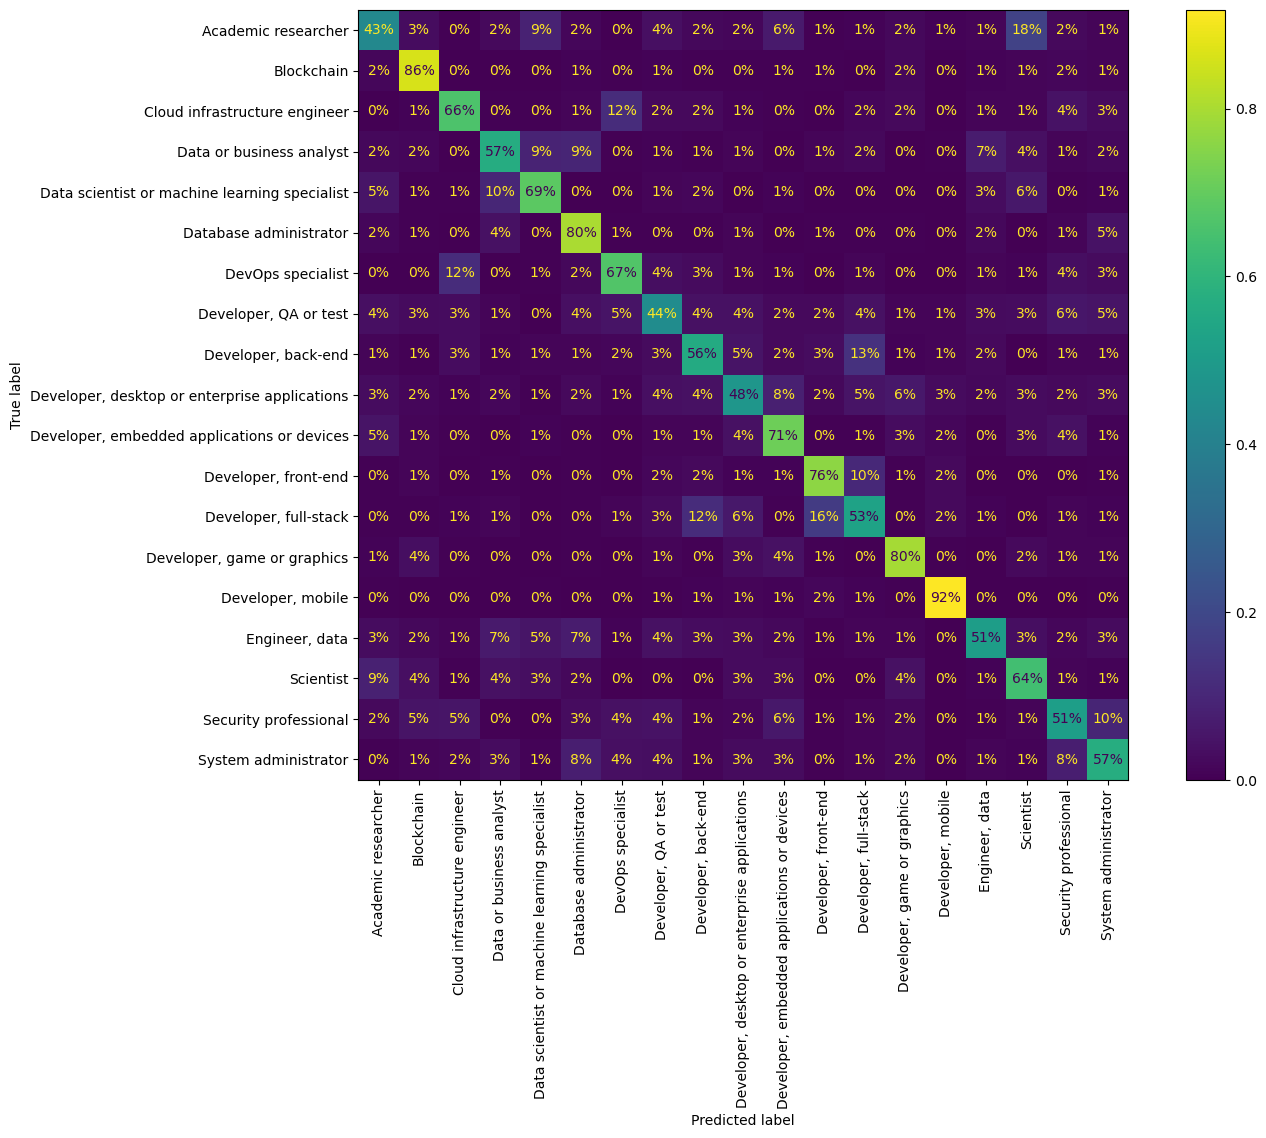

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
cmp = ConfusionMatrixDisplay.from_predictions(y_over, predictions,normalize="true", values_format=".0%",xticks_rotation=90,ax=ax)
plt.rc('font', size=12)

In [43]:
# cross_validate the baseline model on the accuracy, precision, recall and f1
log_clf_scores = cross_validate(log_clf,x_over,y_over, cv=4, scoring =calculate_scores)

In [44]:
scores = ['test_accuracy', 'test_precision','test_recall', 'test_f1']
validation_scores = {}
for score in scores:
    validation_scores[score] = round(log_clf_scores[score].mean()* 100, 2)
validation_scores

{'test_accuracy': 57.15,
 'test_precision': 58.65,
 'test_recall': 57.15,
 'test_f1': 56.8}

In [50]:
# Evaluate on test set
predictions =  pd.DataFrame(log_clf.predict(x_test),
                            columns=y_test.columns)
test_scores = {score.__name__: calculate_quality(y_test, predictions, score) 
                for score in [accuracy_score, precision_score, recall_score, f1_score]}
test_scores = pd.concat(test_scores,axis=1)
mean_test_scores = test_scores.mean()

In [51]:
print(test_scores.mean())
test_scores.sort_values("precision_score")

accuracy_score     51.51
precision_score    30.08
recall_score       38.91
f1_score           32.87
dtype: float64


,accuracy_score,precision_score,recall_score,f1_score
,51.51,30.08,38.91,32.87


### Log Baseline Model

In [116]:
# Save the model's dataset trained on
data_details = {
                # "data_path": DATA_PATH,
                # "training_set": x_train.index.tolist(),
                # "test_indices":     x_test.index.tolist(), 
                # "features_names":   x_train.columns.tolist(),
                # "targets_names":    y_train.columns.tolist()
                "x_train": x_train,
                "x_test":x_test,
                "y_train":y_train,
                "y_test": y_test
}

with open(os.path.join(LOG_PATH, LOG_DATA_PKL), "wb") as output_file:
    pickle.dump(data_details, output_file)

In [117]:
# save the model, model details and model's description
model = {"model_description": "Baseline model: Logistic Regression, multiclass ",
         "model_details": str(log_clf),
         "model_object": log_clf} 

with open(os.path.join(LOG_PATH, LOG_MODEL_PKL), "wb") as output_file:
    pickle.dump(model, output_file)

In [118]:
# save the model metrics
classes_metrics = {"train_scores": train_scores,
                    "validation_scores" : validation_scores} 


with open(os.path.join(LOG_PATH, LOG_METRICS_PKL), "wb") as output_file:
    pickle.dump(classes_metrics, output_file)

In [119]:
# Start a run in the experiment and track current model
with mlflow.start_run(experiment_id=exp.experiment_id, run_name=model["model_description"]):
    # Track pickle files
    mlflow.log_artifacts(LOG_PATH)
    
    # Track metrics 
    for metric, score in validation_scores.items():
        mlflow.log_metric(metric, score)

### Random Forest

In [52]:
rf_clf = make_pipeline(
                       # PCA(n_components=0.95),
                       RandomForestClassifier(n_jobs=-1,
                                              verbose=1,
                                              random_state=42))

rf_clf.fit(x_over, y_over.values.ravel())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42,
                                        verbose=1))])

In [53]:
# Evaluate on train set
predictions =  pd.DataFrame(rf_clf.predict(x_over),
                            columns=y_over.columns)
train_scores = {score.__name__: calculate_quality(y_over, predictions, score) 
                for score in [accuracy_score, precision_score, recall_score, f1_score]}
train_scores = pd.concat(train_scores,axis=1)
mean_train_scores = train_scores.mean()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [54]:
print(train_scores.mean())
train_scores.sort_values("precision_score")

accuracy_score     99.54
precision_score    99.54
recall_score       99.54
f1_score           99.54
dtype: float64


,accuracy_score,precision_score,recall_score,f1_score
,99.54,99.54,99.54,99.54


In [55]:
# cross_validate the baseline model on the accuracy, precision, recall and f1
rf_clf_scores = cross_validate(rf_clf,x_over,y_over.values.ravel(), cv=4, scoring =calculate_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]:

In [56]:
scores = ['test_accuracy', 'test_precision','test_recall', 'test_f1']
validation_scores = {}
for score in scores:
    validation_scores[score] = round(rf_clf_scores[score].mean()* 100, 2)
validation_scores

{'test_accuracy': 78.33,
 'test_precision': 78.22,
 'test_recall': 78.33,
 'test_f1': 77.78}

In [57]:
# Evaluate on test set
predictions =  pd.DataFrame(rf_clf.predict(x_test),
                            columns=y_test.columns)
test_scores = {score.__name__: calculate_quality(y_test, predictions, score) 
                for score in [accuracy_score, precision_score, recall_score, f1_score]}
test_scores = pd.concat(test_scores,axis=1)
mean_test_scores = test_scores.mean()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [58]:
print(test_scores.mean())
test_scores.sort_values("precision_score")

accuracy_score     50.32
precision_score    29.42
recall_score       38.30
f1_score           32.14
dtype: float64


,accuracy_score,precision_score,recall_score,f1_score
,50.32,29.42,38.3,32.14


### Log RandomForest Model

In [143]:
# Model
model = {"model_description": "Random Forest, multiclass",
         "model_details": str(rf_clf),
         "model_object": rf_clf}

with open(os.path.join(LOG_PATH, LOG_MODEL_PKL), "wb") as output_file:
    pickle.dump(model, output_file)

In [144]:
# Performance details
classes_metrics = {"train_scores": train_scores,
                  "validation_scores" : validation_scores}

with open(os.path.join(LOG_PATH, LOG_METRICS_PKL), "wb") as output_file:
    pickle.dump(classes_metrics, output_file)

In [145]:
# Start a run in the experiment and track current model
with mlflow.start_run(experiment_id=exp.experiment_id, run_name=model["model_description"]):
    # Track pickle files
    mlflow.log_artifacts(LOG_PATH)
    
    # Track metrics 
    for metric, score in validation_scores.items():
        mlflow.log_metric(metric, score)

### Decision Tree

In [128]:
from sklearn.tree import DecisionTreeClassifier
dec_clf = DecisionTreeClassifier(random_state=42)

dec_clf.fit(x_train,y_train)

DecisionTreeClassifier(random_state=42)

In [130]:
# Evaluate on train set
predictions =  pd.DataFrame(dec_clf.predict(x_train),
                            columns=y_over.columns)
train_scores = {score.__name__: calculate_quality(y_train, predictions, score) 
                for score in [accuracy_score, precision_score, recall_score, f1_score]}
train_scores = pd.concat(train_scores,axis=1)
mean_train_scores = train_scores.mean()

In [131]:
print(train_scores.mean())
train_scores.sort_values("precision_score")

accuracy_score     99.98
precision_score    99.98
recall_score       99.94
f1_score           99.96
dtype: float64


,accuracy_score,precision_score,recall_score,f1_score
,99.98,99.98,99.94,99.96


In [132]:
# cross_validate the baseline model on the accuracy, precision, recall and f1
rf_clf_scores = cross_validate(dec_clf,x_train,y_train, cv=4, scoring =calculate_scores)

In [133]:
scores = ['test_accuracy', 'test_precision','test_recall', 'test_f1']
validation_scores = {}
for score in scores:
    validation_scores[score] = round(rf_clf_scores[score].mean()* 100, 2)
validation_scores

{'test_accuracy': 45.86,
 'test_precision': 22.68,
 'test_recall': 22.41,
 'test_f1': 22.47}

### Log Decision Tree

In [134]:
# Model
model = {"model_description": "Decision Tree,multiclass",
         "model_details": str(dec_clf),
         "model_object": dec_clf}

with open(os.path.join(LOG_PATH, LOG_MODEL_PKL), "wb") as output_file:
    pickle.dump(model, output_file)

In [135]:
# Performance details
classes_metrics = {"train_scores": train_scores,
                  "validation_scores" : validation_scores}

with open(os.path.join(LOG_PATH, LOG_METRICS_PKL), "wb") as output_file:
    pickle.dump(classes_metrics, output_file)

In [136]:
# Start a run in the experiment and track current model
with mlflow.start_run(experiment_id=exp.experiment_id, run_name=model["model_description"]):
    # Track pickle files
    mlflow.log_artifacts(LOG_PATH)
    
    # Track metrics 
    for metric, score in validation_scores.items():
        mlflow.log_metric(metric, score)

In [42]:
runs = mlflow.search_runs([exp.experiment_id])
runs 

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_recall,metrics.test_precision,metrics.test_accuracy,metrics.test_f1,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.source.name
0,e041381e0ae24a91984de61a708b7fb2,302056893493878655,FINISHED,file:///C:/Users/Ali/Desktop/DS Projects/Tech ...,2024-01-23 12:54:21.280000+00:00,2024-01-23 12:54:21.504000+00:00,26.64,39.86,60.88,28.41,Ali,"Random Forest, multiclass",LOCAL,C:\Users\Ali\mambaforge-pypy3\envs\env1\Lib\si...
1,d30c2c9e98374b3684be5ee5229ee2a3,302056893493878655,FINISHED,file:///C:/Users/Ali/Desktop/DS Projects/Tech ...,2024-01-23 12:53:04.218000+00:00,2024-01-23 12:53:04.322000+00:00,22.41,22.68,45.86,22.47,Ali,"Decision Tree,multiclass",LOCAL,C:\Users\Ali\mambaforge-pypy3\envs\env1\Lib\si...
2,abbe9bf3f2004afbad8081e142c88427,302056893493878655,FINISHED,file:///C:/Users/Ali/Desktop/DS Projects/Tech ...,2024-01-23 12:50:36.090000+00:00,2024-01-23 12:50:36.191000+00:00,33.53,37.74,61.12,34.70,Ali,"Baseline model: Logistic Regression, multiclass",LOCAL,C:\Users\Ali\mambaforge-pypy3\envs\env1\Lib\si...
3,759f14c2a2324af0988488931899e76d,302056893493878655,FINISHED,file:///C:/Users/Ali/Desktop/DS Projects/Tech ...,2024-01-23 12:47:24.200000+00:00,2024-01-23 12:47:24.300000+00:00,22.41,22.68,45.86,22.47,Ali,"Decision Tree, smote, multiclass",LOCAL,C:\Users\Ali\mambaforge-pypy3\envs\env1\Lib\si...
4,129754068ce14caa80a8e26286c15f64,302056893493878655,FINISHED,file:///C:/Users/Ali/Desktop/DS Projects/Tech ...,2024-01-23 12:45:22.348000+00:00,2024-01-23 12:45:22.564000+00:00,78.33,78.22,78.33,77.78,Ali,"Random Forest, Smote, multiclass",LOCAL,C:\Users\Ali\mambaforge-pypy3\envs\env1\Lib\si...
5,66b82504fa8646dfb26fd139a51d1ea8,302056893493878655,FINISHED,file:///C:/Users/Ali/Desktop/DS Projects/Tech ...,2024-01-23 12:38:36.089000+00:00,2024-01-23 12:38:36.191000+00:00,57.15,58.65,57.15,56.80,Ali,"Baseline model: Logistic Regression, Smote, mu...",LOCAL,C:\Users\Ali\mambaforge-pypy3\envs\env1\Lib\si...
6,9a7eafa8d5bd4dd993575163acf3fa21,302056893493878655,FINISHED,file:///C:/Users/Ali/Desktop/DS Projects/Tech ...,2024-01-23 12:02:32.330000+00:00,2024-01-23 12:02:32.442000+00:00,24.15,23.82,14.31,23.96,Ali,Decision Tree,LOCAL,C:\Users\Ali\mambaforge-pypy3\envs\env1\Lib\si...
7,1f3651fa95bf49e28978df84578d36b0,302056893493878655,FINISHED,file:///C:/Users/Ali/Desktop/DS Projects/Tech ...,2024-01-21 22:43:42.038000+00:00,2024-01-21 22:43:43.159000+00:00,14.46,53.42,24.30,19.11,Ali,Random Forest,LOCAL,C:\Users\Ali\mambaforge-pypy3\envs\env1\Lib\si...
8,bcf45169369b4c4f8ee099775e4e3894,302056893493878655,FINISHED,file:///C:/Users/Ali/Desktop/DS Projects/Tech ...,2024-01-21 22:42:43.631000+00:00,2024-01-21 22:42:43.709000+00:00,21.86,53.14,20.05,28.35,Ali,Baseline model: Logistic Regression,LOCAL,C:\Users\Ali\mambaforge-pypy3\envs\env1\Lib\si...


### Playground

##### play 2

In [45]:
# DownSample majority classes and OverSample minority Classes
samples_per_class = 1000
resampled_jobs = []

for job in jobs_df.columns:
    sub_df = jobs_df.loc[jobs_df[job] == 1].copy()
    
    if len(sub_df) < samples_per_class:
        # Upsample
        sub_df = sub_df.sample(samples_per_class, replace=True, random_state=42)
    else:
        # Downsample
        sub_df = sub_df.sample(samples_per_class, random_state=42) 
    
    resampled_jobs.append(sub_df)

In [46]:
jobs_df = pd.concat(resampled_jobs)
jobs_df.sum(axis=0).sort_values()

Blockchain                                       1277
Developer, game or graphics                      1331
Security professional                            1363
Developer, QA or test                            1416
Developer, embedded applications or devices      1725
Scientist                                        1753
Data or business analyst                         1859
Database administrator                           1928
Engineer, data                                   2011
Developer, mobile                                2111
Academic researcher                              2162
System administrator                             2168
Data scientist or machine learning specialist    2240
Cloud infrastructure engineer                    2317
DevOps specialist                                2531
Developer, desktop or enterprise applications    3021
Developer, front-end                             3290
Developer, full-stack                            6509
Developer, back-end         

In [47]:
len(jobs_df)

19000

In [48]:
jobs_df[jobs_df.sum(axis = 1) ==1].sum(axis=0).sort_values()

Database administrator                            42
Cloud infrastructure engineer                     50
Blockchain                                        78
DevOps specialist                                 82
System administrator                              92
Scientist                                        115
Developer, desktop or enterprise applications    158
Security professional                            183
Engineer, data                                   186
Data or business analyst                         195
Developer, game or graphics                      212
Developer, QA or test                            239
Developer, front-end                             250
Data scientist or machine learning specialist    250
Academic researcher                              254
Developer, embedded applications or devices      305
Developer, back-end                              325
Developer, mobile                                357
Developer, full-stack                         

In [49]:
jobs_df =df['Techjobs'].copy()
jobs_df.sum(axis=0).sort_values()

Blockchain                                         736
Security professional                              801
Developer, game or graphics                       1009
Scientist                                         1122
Developer, QA or test                             1425
Data or business analyst                          1666
Database administrator                            1755
Academic researcher                               1819
Engineer, data                                    2091
System administrator                              2099
Developer, embedded applications or devices       2185
Data scientist or machine learning specialist     2268
Cloud infrastructure engineer                     2813
DevOps specialist                                 3350
Developer, mobile                                 4613
Developer, desktop or enterprise applications     5734
Developer, front-end                             10172
Developer, back-end                              19001
Developer,

In [43]:
len(jobs_df)

46408

In [44]:
jobs_df[jobs_df.sum(axis = 1) ==1].sum(axis=0).sort_values()

Blockchain                                         56
Database administrator                             62
Scientist                                         127
Security professional                             146
Cloud infrastructure engineer                     170
Developer, game or graphics                       215
System administrator                              215
DevOps specialist                                 278
Data or business analyst                          315
Developer, QA or test                             351
Engineer, data                                    370
Academic researcher                               440
Data scientist or machine learning specialist     582
Developer, embedded applications or devices       659
Developer, desktop or enterprise applications     869
Developer, mobile                                1633
Developer, front-end                             2818
Developer, back-end                              5918
Developer, full-stack       

In [30]:
balanced_df = df.loc[jobs_df.index].copy()

In [32]:
X = balanced_df.drop(balanced_df[TECH_JOBS],axis = 1).droplevel(0,axis=1).copy()
y = balanced_df[TECH_JOBS].droplevel(0,axis = 1).copy()

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y,test_size=0.20,
                                                    random_state=42)

In [39]:
len(X_train)

21280

In [5]:
def calculate_quality1(ground_truth, predictions, metric_function, sort_values=False):
    quality_scores = []
    if metric_function == accuracy_score:
        quality_scores.append(round(metric_function(ground_truth, predictions) * 100, 2))
    else: 
        quality_scores.append(round(metric_function(ground_truth, predictions,zero_division=0,average='macro') * 100, 2))
        
    quality_scores = pd.Series(quality_scores)
    if sort_values:
        quality_scores = quality_scores.sort_values()
    
    return quality_scores

#### Retrieve best model

In [57]:
best_run= runs.sort_values('metrics.test_precision',ascending=False).iloc[0]

In [58]:
best_run

run_id                                      129754068ce14caa80a8e26286c15f64
experiment_id                                             302056893493878655
status                                                              FINISHED
artifact_uri               file:///C:/Users/Ali/Desktop/DS Projects/Tech ...
start_time                                  2024-01-23 12:45:22.348000+00:00
end_time                                    2024-01-23 12:45:22.564000+00:00
metrics.test_recall                                                    78.33
metrics.test_precision                                                 78.22
metrics.test_accuracy                                                  78.33
metrics.test_f1                                                        77.78
tags.mlflow.user                                                         Ali
tags.mlflow.runName                         Random Forest, Smote, multiclass
tags.mlflow.source.type                                                LOCAL

In [45]:
artifact_path = best_run["artifact_uri"].replace("file:///", "")

In [46]:
model_pkl = os.path.join(artifact_path, LOG_MODEL_PKL)
with open(model_pkl, "rb") as f:
    model = pickle.load(f)

model['model_object']

DecisionTreeClassifier(random_state=42)